### 1) Imports & NLTK setup

In [1]:
import os
import re
import time
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2) Download dataset

In [2]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("kritanjalijain/amazon-reviews")
print("Path to dataset files:", path)

# Use `path` instead of `dataset_dir`
train_path = os.path.join(path, "train.csv")
test_path  = os.path.join(path, "test.csv")

Path to dataset files: /kaggle/input/


### 3) Load CSVs with correct headers

In [3]:
train_df = pd.read_csv(train_path, header=None, names=['polarity','title','text'])
test_df  = pd.read_csv(test_path,  header=None, names=['polarity','title','text'])

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
train_df.head()

Train shape: (3600000, 3)
Test shape : (400000, 3)


,polarity,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


### Combine title + text and map labels to {0,1}

In [4]:
train_df['combined'] = train_df['title'].astype(str) + " " + train_df['text'].astype(str)
test_df['combined']  = test_df['title'].astype(str)  + " " + test_df['text'].astype(str)

# Map polarity: 1 -> 0 (negative), 2 -> 1 (positive)
train_df['label'] = train_df['polarity'].map({1:0, 2:1})
test_df['label']  = test_df['polarity'].map({1:0, 2:1})

print(train_df[['polarity','label']].value_counts())

polarity  label
1         0        1800000
2         1        1800000
Name: count, dtype: int64


### Text-cleaning function and apply
We’ll clean the combined review text by:
- Lowercasing
- Removing punctuation, numbers, and URLs
- Removing extra spaces

In [5]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already present
nltk.download('stopwords')

# Define stopword list
STOP_WORDS = set(stopwords.words('english'))

def clean_text(text):
    text = str(text)
    text = re.sub(r'\\n', ' ', text)           # escaped newline sequences
    text = re.sub(r'http\S+', ' ', text)       # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)   # keep only letters/spaces
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()   # remove extra spaces
    tokens = [w for w in text.split() if w not in STOP_WORDS]
    return " ".join(tokens)

# Combine title + text before cleaning
train_df['combined'] = train_df['title'].astype(str) + " " + train_df['text'].astype(str)
test_df['combined']  = test_df['title'].astype(str) + " " + test_df['text'].astype(str)

# Apply cleaning
train_df['clean_text'] = train_df['combined'].apply(clean_text)
test_df['clean_text']  = test_df['combined'].apply(clean_text)

# Check results
train_df[['combined','clean_text']].head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,combined,clean_text
0,Stuning even for the non-gamer This sound trac...,stuning even non gamer sound track beautiful p...
1,The best soundtrack ever to anything. I'm read...,best soundtrack ever anything reading lot revi...
2,Amazing! This soundtrack is my favorite music ...,amazing soundtrack favorite music time hands i...
3,Excellent Soundtrack I truly like this soundtr...,excellent soundtrack truly like soundtrack enj...
4,"Remember, Pull Your Jaw Off The Floor After He...",remember pull jaw floor hearing played game kn...


### TF-IDF vectorization
Convert text to numeric form for model input.

In [6]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english', sublinear_tf=True)

X_train = vectorizer.fit_transform(train_df['clean_text'])
X_test  = vectorizer.transform(test_df['clean_text'])
y_train = train_df['label'].values
y_test  = test_df['label'].values

print("TF-IDF shapes:", X_train.shape, X_test.shape)

TF-IDF shapes: (3600000, 5000) (400000, 5000)


### Evaluation & confusion matrix plot

In [7]:
def evaluate_and_report(model, X_train_local, y_train_local, X_test_local, y_test_local, show_cm=True):
    start = time.time()
    model.fit(X_train_local, y_train_local)
    train_time = time.time() - start

    y_pred = model.predict(X_test_local)
    acc = accuracy_score(y_test_local, y_pred)
    prec = precision_score(y_test_local, y_pred)
    rec = recall_score(y_test_local, y_pred)
    f1 = f1_score(y_test_local, y_pred)

    print(f"\n {model.__class__.__name__} ")
    print(f"Train time (s): {train_time:.2f}")
    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test_local, y_pred))

    if show_cm:
        cm = confusion_matrix(y_test_local, y_pred)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos'])
        plt.title(f"{model.__class__.__name__} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return {'model': model.__class__.__name__, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'train_time': train_time}

### Hyperparameter tuning + cross-validation

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Logistic Regression
print("\nTuning Logistic Regression")
lr = LogisticRegression(max_iter=500, n_jobs=-1)
lr_params = {'C': [0.1, 1.0, 3.0], 'solver': ['liblinear','lbfgs']}

lr_gs = GridSearchCV(lr, lr_params, scoring='f1', cv=3, n_jobs=-1, verbose=1)
lr_gs.fit(X_train, y_train)
best_lr = lr_gs.best_estimator_
print("Best LR params:", lr_gs.best_params_, "| Best CV F1:", round(lr_gs.best_score_, 4))


# Naive Bayes
print("\n Tuning Naive Bayes...")
nb = MultinomialNB()
nb_params = {'alpha': [0.1, 0.5, 1.0]}

nb_gs = GridSearchCV(nb, nb_params, scoring='f1', cv=3, n_jobs=-1, verbose=1)
nb_gs.fit(X_train, y_train)
best_nb = nb_gs.best_estimator_
print("Best NB params:", nb_gs.best_params_, "| Best CV F1:", round(nb_gs.best_score_, 4))

# LightGBM
print("\nTuning LightGBM")
lgb_model = LGBMClassifier(
    random_state=42,
    device='gpu',            
    force_col_wise=True,     
    n_jobs=1                  
)

lgb_params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [-1, 10]
}

lgb_rs = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_params,
    n_iter=6,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=1,                 
    verbose=1
)
lgb_rs.fit(X_train, y_train)
best_lgb = lgb_rs.best_estimator_
print("Best LGB params:", lgb_rs.best_params_, "| Best CV F1:", round(lgb_rs.best_score_, 4))


# XGBoost
print("\nTuning XGBoost")
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=1,             # CPU threads for preprocessing
    tree_method='gpu_hist' # GPU acceleration
)

xgb_params = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

xgb_rs = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_params,
    n_iter=6,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=1,        # avoid oversubscription
    verbose=1
)
xgb_rs.fit(X_train, y_train)
best_xgb = xgb_rs.best_estimator_
print("Best XGB params:", xgb_rs.best_params_, "| Best CV F1:", round(xgb_rs.best_score_, 4))


Tuning Logistic Regression
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  

Best LR params: {'C': 3.0, 'solver': 'lbfgs'} | Best CV F1: 0.8904

 Tuning Naive Bayes...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best NB params: {'alpha': 1.0} | Best CV F1: 0.8502

Tuning LightGBM
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LightGBM] [Info] Number of positive: 1200000, number of negative: 1200000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 785247
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 5000
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1200000, number of negative: 1200000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 787628
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 5000
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1200000, number of negative: 1200000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 789416
[LightGB

### Train & evaluate tuned models


 MultinomialNB 
Train time (s): 0.84
Accuracy: 0.8490  Precision: 0.8436  Recall: 0.8569  F1: 0.8502

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85    200000
           1       0.84      0.86      0.85    200000

    accuracy                           0.85    400000
   macro avg       0.85      0.85      0.85    400000
weighted avg       0.85      0.85      0.85    400000



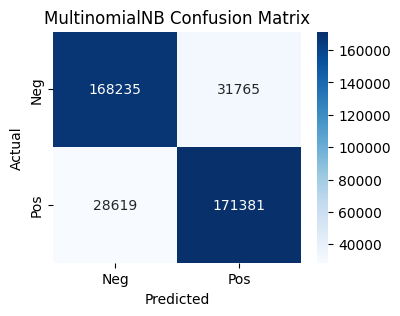


 LogisticRegression 
Train time (s): 124.08
Accuracy: 0.8905  Precision: 0.8862  Recall: 0.8961  F1: 0.8911

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89    200000
           1       0.89      0.90      0.89    200000

    accuracy                           0.89    400000
   macro avg       0.89      0.89      0.89    400000
weighted avg       0.89      0.89      0.89    400000



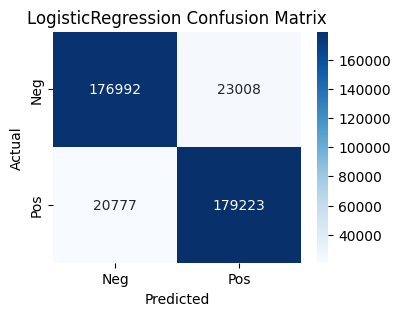

[LightGBM] [Info] Number of positive: 1800000, number of negative: 1800000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 788503
[LightGBM] [Info] Number of data points in the train set: 3600000, number of used features: 5000
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

 LGBMClassifier 
Train time (s): 579.49
Accuracy: 0.8747  Precision: 0.8667  Recall: 0.8857  F1: 0.8761

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87    200000
           1       0.87      0.89      0.88    200000

    accuracy                           0.87    400000
   macro avg       0.87      0.87      0.8

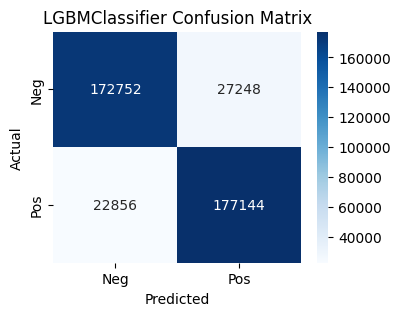


 XGBClassifier 
Train time (s): 56.77
Accuracy: 0.5764  Precision: 0.5752  Recall: 0.5841  F1: 0.5796

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.57      0.57    200000
           1       0.58      0.58      0.58    200000

    accuracy                           0.58    400000
   macro avg       0.58      0.58      0.58    400000
weighted avg       0.58      0.58      0.58    400000



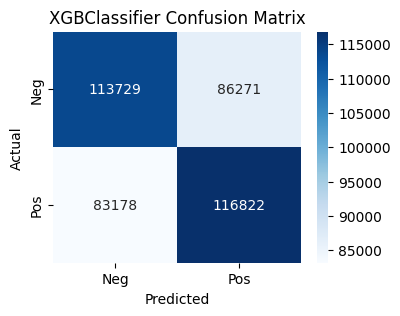


Model comparison after tuning:
                 model  accuracy  precision    recall        f1  train_time
0  LogisticRegression  0.890537   0.886229  0.896115  0.891145  124.084832
1      LGBMClassifier  0.874740   0.866688  0.885720  0.876100  579.487013
2      LGBMClassifier  0.874740   0.866688  0.885720  0.876100  579.487013
3       MultinomialNB  0.849040   0.843635  0.856905  0.850218    0.841732


In [9]:
results = []

# Evaluate best_nb
res_nb = evaluate_and_report(best_nb, X_train, y_train, X_test, y_test)
results.append(res_nb)

# Evaluate best_lr
res_lr = evaluate_and_report(best_lr, X_train, y_train, X_test, y_test)
results.append(res_lr)

# Evaluate best_lgb
res_lgb = evaluate_and_report(best_lgb, X_train, y_train, X_test, y_test)
results.append(res_lgb)

res_xgb = evaluate_and_report(best_xgb, X_train, y_train, X_test, y_test)
results.append(res_lgb)

results_df = pd.DataFrame(results).sort_values(by='f1', ascending=False).reset_index(drop=True)
print("\nModel comparison after tuning:\n", results_df)

### Inspect misclassified examples for business insight
**Purpose:**

To find out where your model goes wrong, i.e., the reviews it misclassifies.

Example:
- The model predicts Positive, but the true label is Negative.
- These cases often reveal: Ambiguous or sarcastic reviews. Missing context (“It was too good to be true!”). Vocabulary gaps in the model.

Business Value:
1. Improve training data quality - you can identify noisy or mislabeled samples.
2. Understand customer tone - e.g., model struggles with sarcasm or mixed sentiment.
3. Refine preprocessing - maybe stopwords or negation (“not good”) are not handled well.
4. Guide future feature engineering - like using word embeddings or transformer-based models.

In [10]:
# Choose the best model by F1 from results_df
best_model_name = results_df.loc[0, 'model']
print("Selected best model:", best_model_name)

model_map = {'MultinomialNB': best_nb, 'LogisticRegression': best_lr, 'LGBMClassifier': best_lgb}
best_model = model_map[best_model_name]

# Get predictions on test set
y_pred = best_model.predict(X_test)

# Misclassified indices
mis_idx = np.where(y_pred != y_test)[0]
print("Total misclassified:", len(mis_idx))

# Show first 10 misclassified examples for qualitative business insight
for i in mis_idx[:10]:
    true_label = "Positive" if y_test[i] == 1 else "Negative"
    pred_label = "Positive" if y_pred[i] == 1 else "Negative"
    print("-------------------------------------------------")
    print(f"Index: {i} | True: {true_label} | Pred: {pred_label}")
    print("Original text (truncated):")
    print(test_df.iloc[i]['combined'][:500])
    print()

Selected best model: LogisticRegression
Total misclassified: 43785
-------------------------------------------------
Index: 7 | True: Negative | Pred: Positive
Original text (truncated):
DVD menu select problems I cannot scroll through a DVD menu that is set up vertically. The triangle keys will only select horizontally. So I cannot select anything on most DVD's besides play. No special features, no language select, nothing, just play.

-------------------------------------------------
Index: 9 | True: Negative | Pred: Positive
Original text (truncated):
Not an "ultimate guide" Firstly,I enjoyed the format and tone of the book (how the author addressed the reader). However, I did not feel that she imparted any insider secrets that the book promised to reveal. If you are just starting to research law school, and do not know all the requirements of admission, then this book may be a tremendous help. If you have done your homework and are looking for an edge when it comes to admissions, I

### Save the best TF-IDF vectorizer and best model as .joblib

In [11]:
# Save vectorizer
joblib.dump(vectorizer, "best_tfidf_vectorizer.joblib")
# Save model
joblib.dump(best_model, f"best_model_{best_model_name}.joblib")

print("Saved: best_tfidf_vectorizer.joblib and best_model_{}.joblib".format(best_model_name))

Saved: best_tfidf_vectorizer.joblib and best_model_LogisticRegression.joblib


### Load saved artifacts and quick verify predictions

In [12]:
vec_loaded = joblib.load("best_tfidf_vectorizer.joblib")
model_loaded = joblib.load(f"best_model_{best_model_name}.joblib")

sample_texts = [
    "I absolutely love this product, it works perfectly!",
    "Terrible product. Broke in two days and customer service ignored me."
]
sample_clean = [clean_text(t) for t in sample_texts]
sample_vec = vec_loaded.transform(sample_clean)
preds = model_loaded.predict(sample_vec)

for text, p in zip(sample_texts, preds):
    print("Text:", text)
    print("Predicted:", "Positive" if p==1 else "Negative")
    print()

Text: I absolutely love this product, it works perfectly!
Predicted: Positive

Text: Terrible product. Broke in two days and customer service ignored me.
Predicted: Negative

